### Entropy Pooling

In [112]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from scipy.optimize import minimize, Bounds
from typing import Tuple

def EntropyPooling(
        p: pd.Series, 
        A: pd.DataFrame, 
        b: pd.Series
) -> pd.Series:
    len_p = len(p)
    lhs = A
    rhs = b
    bounds = Bounds([-np.inf] * len_p, [np.inf] * len_p)  # Multipliers can be negative
    
    log_p = np.log(p.values + 1e-10)  # Avoid log(0) error
    dual_solution = minimize(
        dual_objective,
        x0=np.zeros(lhs.shape[0]),  # Initial guess for the multipliers
        args=(log_p, lhs.values, rhs.values),
        method='TNC',
        jac=True,
        bounds=bounds,
        options={'maxfun': 10000, 'disp': True}
    )
    q_values = np.exp(log_p - 1 - lhs.T @ dual_solution.x)
    
    # Ensure the output is a pandas Series correctly formatted
    return pd.Series(q_values, index=p.index)


def dual_objective(
        lagrange_multipliers: np.ndarray, 
        log_p: np.ndarray, 
        lhs: np.ndarray, 
        rhs: np.ndarray
) -> Tuple[float, np.ndarray]:
    """Corrected dual objective function to ensure it returns a scalar for the objective."""
    # Lagrange multipliers should be 2D for matrix operations
    lagrange_multipliers = lagrange_multipliers[:, np.newaxis]
    
    # Calculate x and its logarithm using the current lagrange multipliers
    log_x = log_p - 1 - (lhs.T @ lagrange_multipliers).flatten()
    x = np.exp(log_x)
    
    # Compute the gradient of the dual objective
    gradient = (rhs - lhs @ x).flatten()
    
    # Compute the dual objective function value
    objective = x.T @ (log_x - log_p) - (lagrange_multipliers.flatten().T @ gradient)
    
    return -objective.item(), -gradient

In [113]:
TICKERS = ['SPY','VTV','GLD','USO','CPER','IJH','IJR']
START = '2015-01-01'
END = '2022-12-31'

data = yf.download(
    TICKERS,
    start = START,
    end = END,
    progress = False,
    interval = '1d'
)['Close']

In [114]:
ret = data.pct_change().dropna()

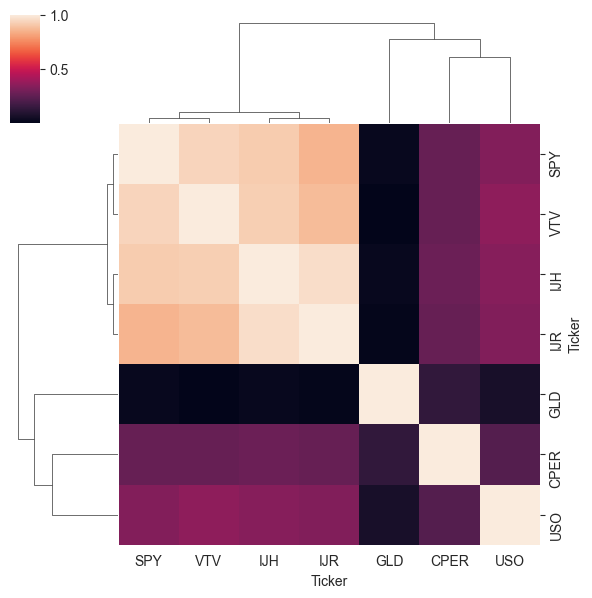

In [115]:
sns.clustermap(ret.corr(), figsize = (6, 6))

In [116]:
p = pd.Series(np.ones(len(TICKERS)) / len(TICKERS), index=ret.columns)

# Define the constraints A (identity matrix, for weights summing to 1) and b (vector of ones)
A = pd.DataFrame(np.eye(len(TICKERS)), index=ret.columns, columns=ret.columns)
b = pd.Series(np.ones(len(TICKERS)), index=ret.columns)

final_optimal_weights = EntropyPooling(p, A, b)
final_optimal_weights

  NIT   NF   F                       GTG
    0    1  3.678794414289580E-01   6.28357473E+00
    0   54  3.678794414289580E-01   6.28357473E+00
tnc: Linear search failed


Ticker
CPER    0.052554
GLD     0.052554
IJH     0.052554
IJR     0.052554
SPY     0.052554
USO     0.052554
VTV     0.052554
dtype: float64